In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import inspect


### Portfolio Optimization with Blue Water Macro Data

This notebook demonstrates how to use the `PortfolioOptimizer` module to build optimized portfolios using Blue Water Macro data. The goal is to:

1. Provide portfolio optimization tools using curated return and risk data
2. Support multiple risk model frameworks (historical, factor-based, etc.)
3. Enable flexible optimization criteria (e.g., Sharpe maximization, minimum variance)

The `PortfolioOptimizer` module is built **on top of** [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/), a powerful but complex portfolio optimization library. `PortfolioOptimizer` simplifies the interface, allowing users to run common portfolio construction workflows without dealing with Riskfolio's detailed configuration.


In [2]:
import PortfolioOptimizer

**Input Data: Xarray Dataset**

The PortfolioOptimizer expects an input in the form of an xarray.Dataset, which contains the necessary financial data (e.g., returns, factor exposures, etc.). To keep the interface clean and flexible, the optimizer assumes that the user has already sliced the dataset to the desired date range and set of tickers before passing it in.

In [3]:
sandbox_df = pd.read_csv('./sandbox_testing.csv')
sandbox_df['date'] = pd.to_datetime(sandbox_df['date'])
sandbox_df.set_index(['date', 'ticker'], inplace=True)

sandbox_ds = xr.Dataset.from_dataframe(sandbox_df)

In [4]:
classic_mvo = PortfolioOptimizer.ClassicOptimizer(sandbox_ds)

In [26]:
classic_mvo.optimize(returns_col='residual_return', LongOnly=False)

In [27]:
classic_mvo.w

,weights
AMZN,4.073570e-11
GOOG,3.953854e-11
JNJ,3.534339e-01
JPM,1.053420e-01
META,8.422525e-02
NFLX,2.353067e-01
NVDA,1.342810e-01
PG,4.682007e-10
UNH,1.507371e-11
XOM,8.741117e-02


In [28]:
classic_mvo.port.sht

True

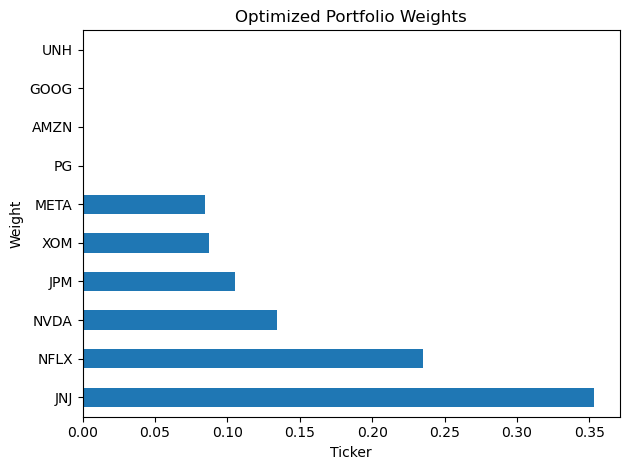

In [29]:
classic_mvo.plot_weights()

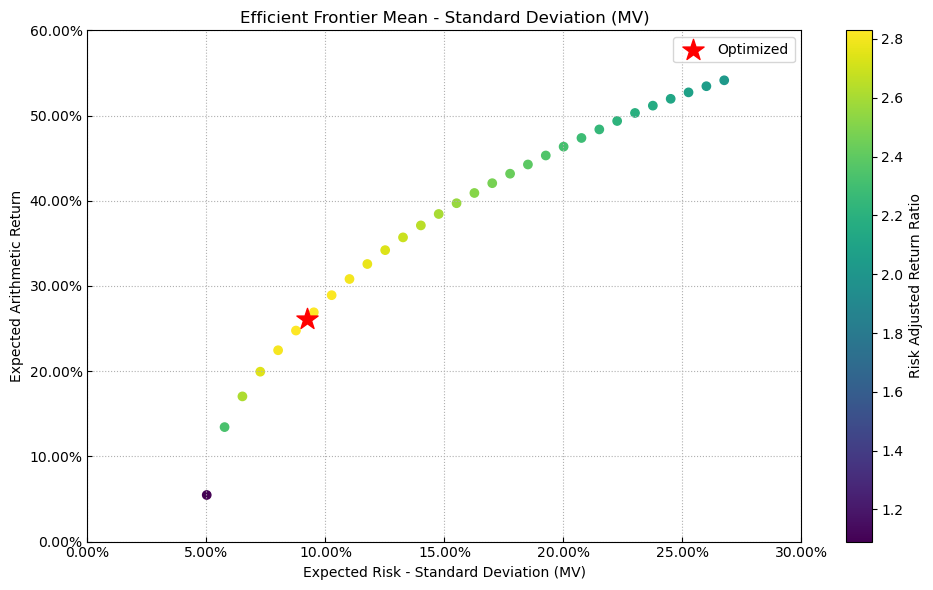

In [30]:
classic_mvo.plot_frontier()

In [31]:
classic_mvo.w.sum()

weights    1.0
dtype: float64

In [32]:
classic_mvo.port.budget

1.0

### Construction of the Covariance Matrix (Σ)

The total asset return covariance matrix **Σ** is constructed using the factor model equation:

$$
\Sigma = BFB^\top + D
$$

Where:

* **B** is the matrix of asset exposures to systematic risk factors (e.g., market, sector).
* **F** is the **factor covariance matrix**, computed from historical factor returns.
* **D** is the **diagonal residual variance matrix**, containing the idiosyncratic risk of each asset.

This formulation decomposes total risk into:

* **Systematic risk**, driven by common factor exposures (captured by $BFB^\top$),
* **Idiosyncratic risk**, unique to each asset (captured by D).

### Construction of Expected Returns (μ)

In this model, the expected return vector **μ** is calculated using the equation:

$$
\mu = B \cdot f
$$

Where:

* **B** is the matrix of asset exposures to systematic risk factors (e.g., market, sectors).
* **f** is the vector of expected returns for each factor, typically computed as the average of trailing factor returns.

This approach estimates the **gross expected return** of each asset **based solely on its factor exposures**.
It **does not include residual (idiosyncratic) components**, which are captured separately in the residual variance matrix **D**.

In [33]:
factor_model = PortfolioOptimizer.FactorModelOptimizer(sandbox_ds)

In [34]:
factor_model.validate_config() # Accept FM defaults
factor_model.calculate_fm_cov()

In [35]:
factor_model.B

,market_beta,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Information_Technology
ticker,,,,,,,
AMZN,1.277207,0.882588,0.000000,0.000000,0.000000,0.000000,0.000000
GOOG,0.980433,0.000000,0.000000,0.000000,0.000000,0.000000,0.632269
JNJ,0.054475,0.000000,0.000000,0.000000,0.000000,1.213641,0.000000
JPM,0.828953,0.000000,0.000000,0.000000,1.154365,0.000000,0.000000
META,1.402877,0.000000,0.000000,0.000000,0.000000,0.000000,0.284589
NFLX,0.872773,0.000000,0.000000,0.000000,0.000000,0.000000,0.512731
NVDA,1.779406,0.000000,0.000000,0.000000,0.000000,0.000000,2.987132
PG,0.225643,0.000000,1.145556,0.000000,0.000000,0.000000,0.000000
UNH,0.193692,0.000000,0.000000,0.000000,0.000000,0.773088,0.000000


In [36]:
factor_model.f

,f
Market,0.000612
Consumer_Discretionary,0.000221
Consumer_Staples,0.000107
Energy,-0.000406
Financials,0.000505
Health_Care,-0.000590
Information_Technology,-0.000164


In [37]:
factor_model.F

,Market,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Information_Technology
Market,0.000163,-0.000026,-0.000004,0.000042,0.000008,0.000011,-0.000013
Consumer_Discretionary,-0.000026,0.000057,-0.000002,-0.000018,0.000002,-0.000013,-0.000005
Consumer_Staples,-0.000004,-0.000002,0.000063,0.000006,0.000017,0.000035,-0.000032
Energy,0.000042,-0.000018,0.000006,0.000161,0.000034,0.000011,-0.000034
Financials,0.000008,0.000002,0.000017,0.000034,0.000059,0.000016,-0.000034
Health_Care,0.000011,-0.000013,0.000035,0.000011,0.000016,0.000065,-0.000030
Information_Technology,-0.000013,-0.000005,-0.000032,-0.000034,-0.000034,-0.000030,0.000050


In [38]:
factor_model.D

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
ticker,,,,,,,,,,
AMZN,0.015789,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000
GOOG,0.000000,0.021605,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000
JNJ,0.000000,0.000000,0.008323,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000
JPM,0.000000,0.000000,0.000000,0.007559,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000
META,0.000000,0.000000,0.000000,0.000000,0.02394,0.000000,0.0000,0.000000,0.000000,0.000000
NFLX,0.000000,0.000000,0.000000,0.000000,0.00000,0.028261,0.0000,0.000000,0.000000,0.000000
NVDA,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0318,0.000000,0.000000,0.000000
PG,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.005727,0.000000,0.000000
UNH,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.062626,0.000000


In [39]:
factor_model.sigma

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
ticker,,,,,,,,,,
AMZN,0.016041,0.000169,1.413673e-05,0.000168,0.000254,1.511648e-04,0.000267,0.000034,0.000039,0.000129
GOOG,0.000169,0.021765,-1.388916e-06,0.000109,0.000218,1.419292e-04,0.000326,0.000006,0.000023,0.000095
JNJ,0.000014,-0.000001,8.420315e-03,0.000042,0.000021,6.372259e-07,-0.000071,0.000054,0.000066,0.000026
JPM,0.000168,0.000109,4.158184e-05,0.007764,0.000188,9.992153e-05,0.000105,0.000051,0.000049,0.000144
META,0.000254,0.000218,2.119891e-05,0.000188,0.024255,1.943364e-04,0.000387,0.000034,0.000049,0.000160
NFLX,0.000151,0.000142,6.372259e-07,0.000100,0.000194,2.838681e-02,0.000284,0.000008,0.000022,0.000086
NVDA,0.000267,0.000326,-7.130529e-05,0.000105,0.000387,2.835378e-04,0.032624,-0.000061,-0.000006,0.000099
PG,0.000034,0.000006,5.359152e-05,0.000051,0.000034,7.740617e-06,-0.000061,0.005815,0.000039,0.000032
UNH,0.000039,0.000023,6.576006e-05,0.000049,0.000049,2.197560e-05,-0.000006,0.000039,0.062674,0.000036


In [40]:
factor_model.optimize(LongOnly=False)

In [41]:
factor_model.w.sum()

weights    1.0
dtype: float64

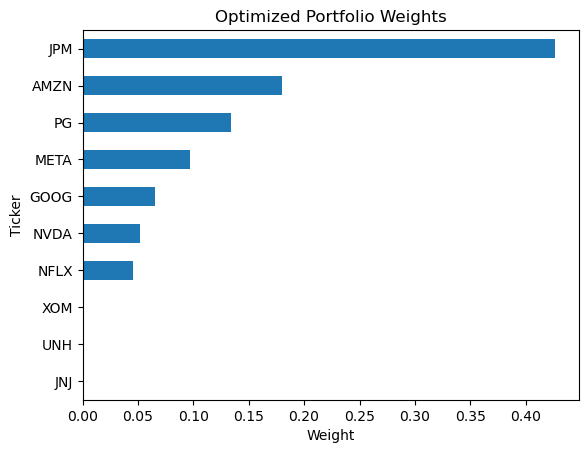

In [42]:
factor_model.plot_weights()

In [43]:
factor_model.w

,weights
AMZN,1.804864e-01
GOOG,6.505801e-02
JNJ,-4.301213e-10
JPM,4.263617e-01
META,9.662268e-02
NFLX,4.513633e-02
NVDA,5.204366e-02
PG,1.342913e-01
UNH,6.187791e-10
XOM,1.190104e-09


In [44]:
factor_model.mu

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
0,0.000976,0.000496,-0.000683,0.001091,0.000812,0.00045,0.000598,0.000261,-0.000338,-0.000096


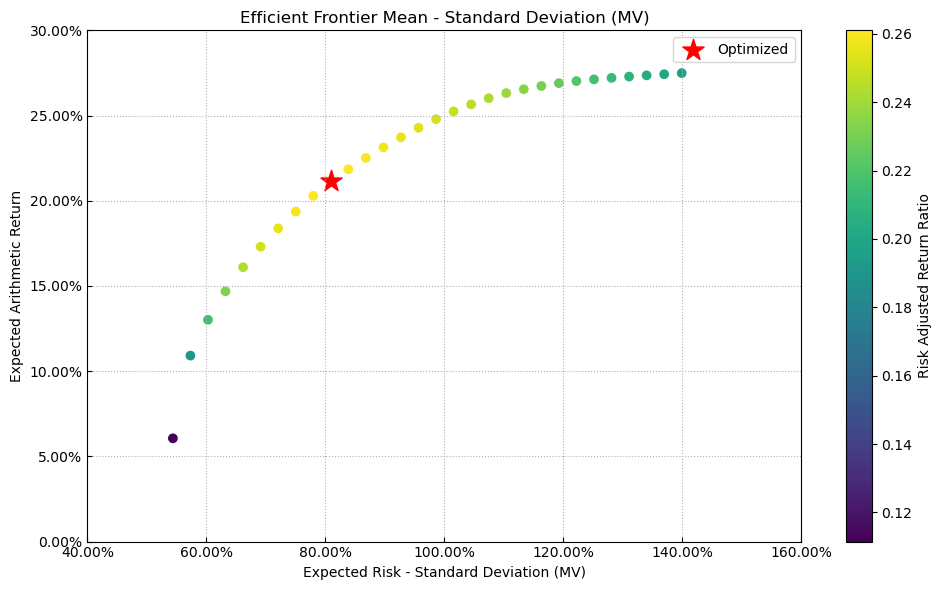

In [45]:
factor_model.plot_frontier()